In [2]:
%cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_0408_posEmbed
!pwd

/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_0408_posEmbed
/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_0408_posEmbed


In [3]:
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image

In [4]:
from model import *
from dataset import *

# Load YAML.
cfg = OmegaConf.load('config.yaml')
seed = cfg.training.seed
batch_size = cfg.training.batch_size
num_slots = cfg.attention.num_slots
num_iters = cfg.attention.num_iters
resolution = tuple(cfg.dataset.resolution)

# Set target frame.
frame = 10

# Load val dataset.
val_dir = '/home/skyworker/result/4DGS_SlotAttention/shape_of_motion/'
val_seq = 'movi_a_0020_anoMask'
test_set = ShapeOfMotion(os.path.join(val_dir,val_seq), cfg.dataset)

# Load model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SlotAttentionAutoEncoder(cfg.dataset, cfg.cnn, cfg.attention).to(device)
model.load_state_dict(torch.load(os.path.join('checkpoints','last.ckpt' ))['model_state_dict'])

# Inference.
model = model.to(device)
sample = test_set[frame]
image = sample['gt_imgs'].to(device)

if cfg.attention.use_all_gs:   
    gs = sample['all_gs']
    pos_embed = sample['all_gs_pos']
else:
    gs = sample['fg_gs']
    pos_embed = sample['fg_gs_pos']

image = image[None]
gs = gs[None].to(device)
pos_embed = pos_embed.to(device)

recon_combined, recons, masks, slots = model(gs, pos_embed)
# Squeeze.
image = image.squeeze(0)
recon_combined = recon_combined.squeeze(0)
recons = recons.squeeze(0)
masks = masks.squeeze(0)

# Convert to numpy.
image = image.cpu().detach().numpy()
recon_combined = recon_combined.cpu().detach().numpy()
recons = recons.cpu().detach().numpy()
masks = masks.cpu().detach().numpy()

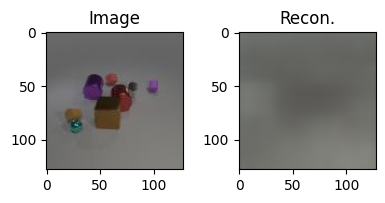

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
# plt.imshow(image, cmap='gray')
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
plt.tight_layout()

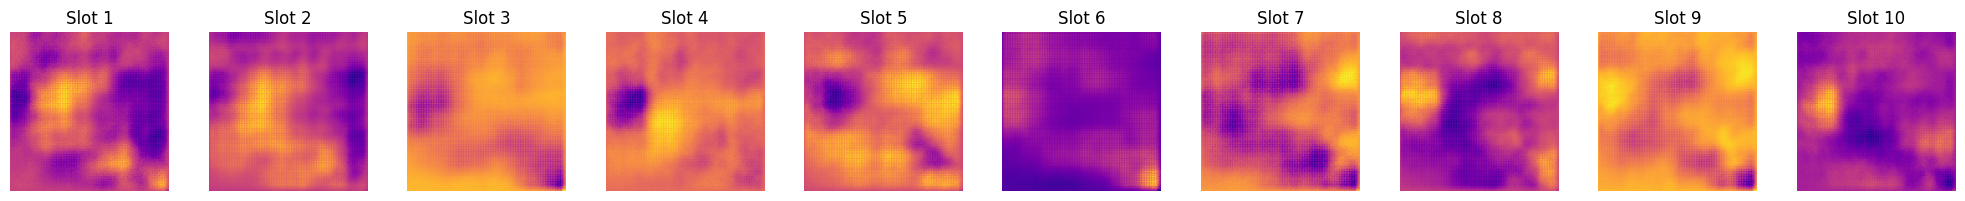

In [8]:
fig, ax = plt.subplots(1, num_slots, figsize=(20, 2))
for i in range(num_slots):
  picture = masks[i]
  # picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i].imshow(picture, cmap="plasma")
  ax[i].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')
plt.tight_layout()